## Moving Average Model

1. Maths behind the model
2. Coding
3. Selecting the Model
4. Coefficients and LLF
5. Residual analysis
6. Logs analysis
7. Price predictions

The MA model includes past residuals while the AR model includes past values.

### Simple Moving Average

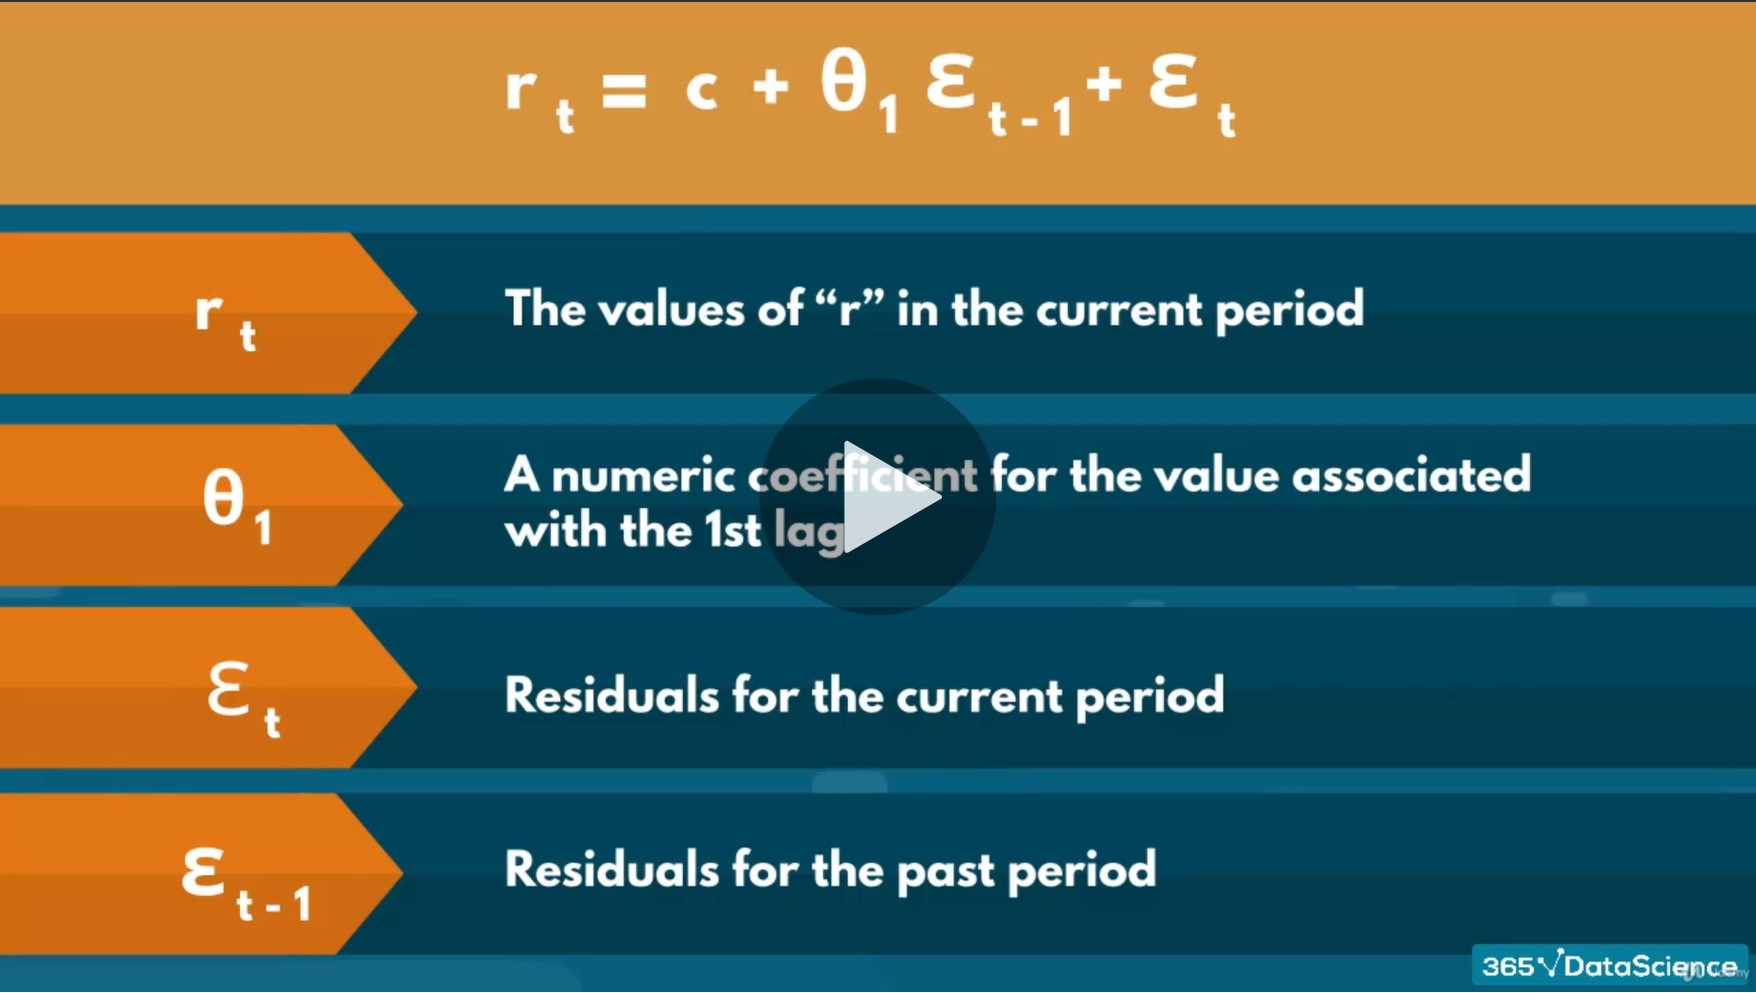

In [1]:
from IPython.display import Image
Image(filename='SimpleMAF.jpg')

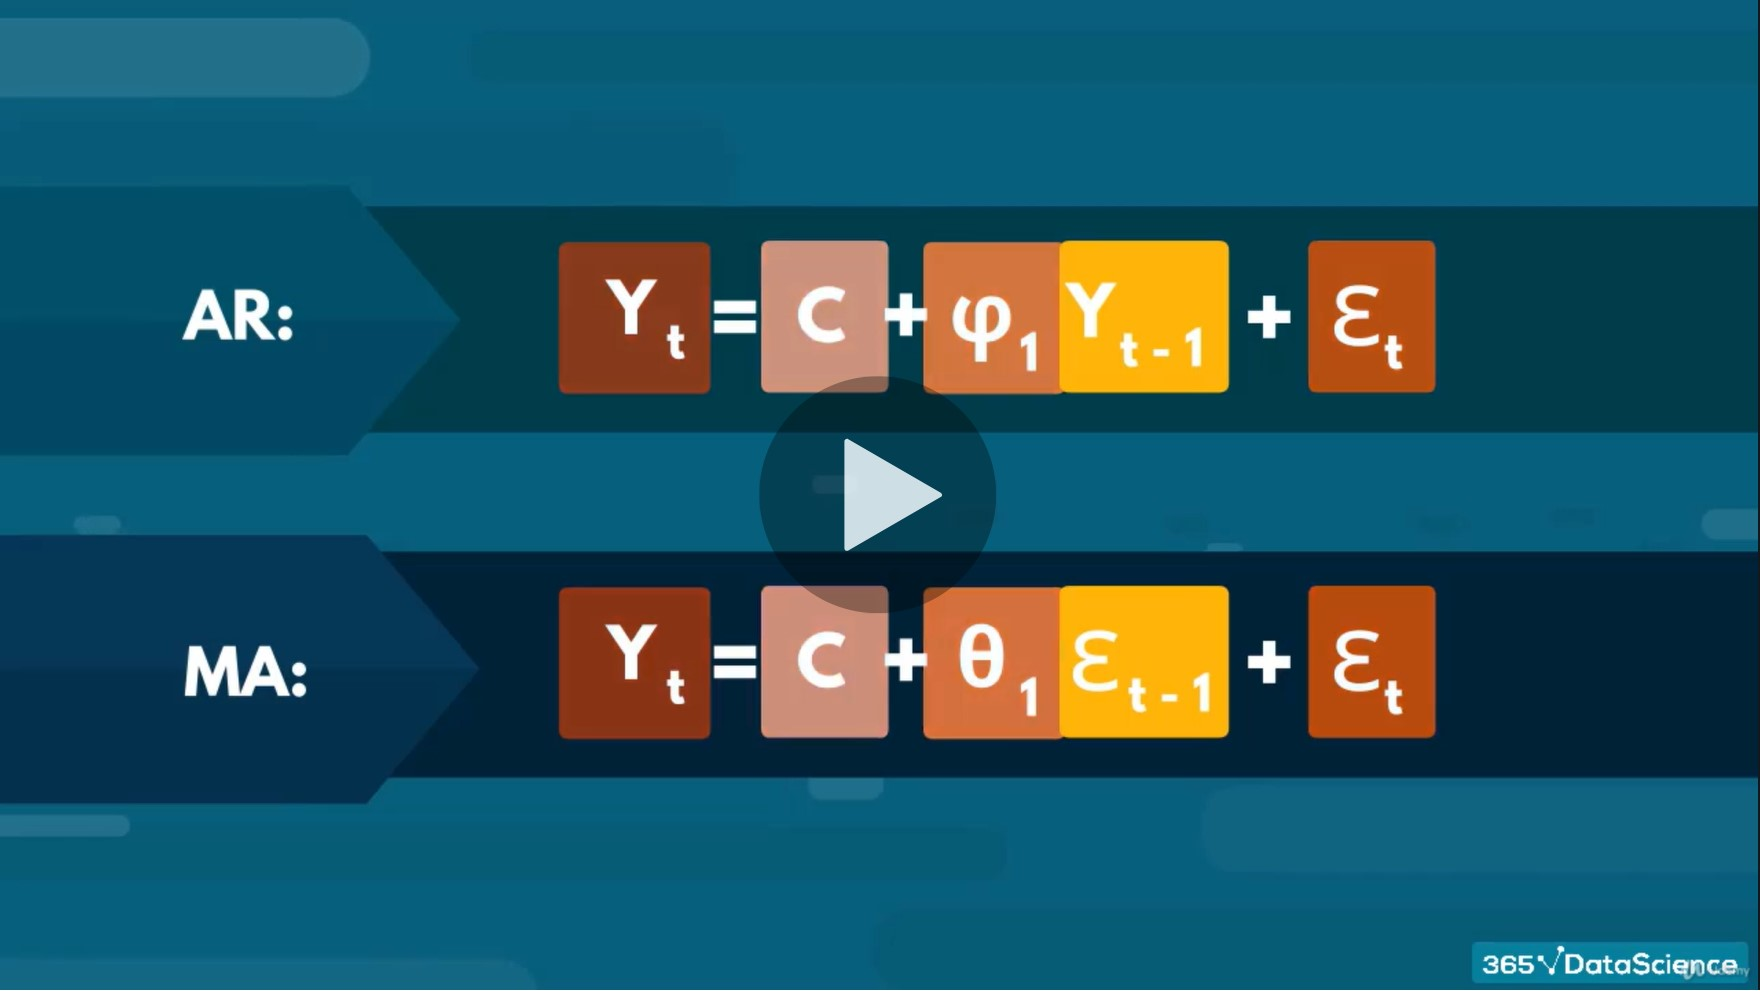

In [2]:
Image(filename='ARvsMA.jpg')

### Please read the AR and MA pdf files associated with Moving averages

In [3]:
import numpy as np
import pandas as pd
import yfinance 

# Ignoring warning messages
import warnings 
warnings.filterwarnings("ignore")

In [4]:
# Getting the current date
from datetime import date
today = date.today()
today

datetime.date(2020, 7, 21)

In [5]:
# Using the .download() method to get our data

raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", #The time series we are interested in - (in our case, these are the S&P, FTSE, NIKKEI and DAX)
                              start = "1994-01-07", #The starting date of our data set
                              end = today, #The ending date of our data set (at the time of upload, this is the current date)
                              interval = "1d", #The distance in time between two recorded observations. Since we're using daily closing prices, we set it equal to "1d", which indicates 1 day. 
                              group_by = 'ticker', #The way we want to group the scraped data. Usually we want it to be "ticker", so that we have all the information about a time series in 1 variable.
                              auto_adjust = True, #Automatically adjuss the closing prices for each period. 
                              treads = True) #Whether to use threads for mass downloading.

[*********************100%***********************]  4 of 4 completed


In [6]:
# Creating a back up copy in case we remove/alter elements of the data by mistake
df_comp = raw_data.copy()

In [7]:
# Adding new columns to the data set
df_comp['spx'] = df_comp['^GSPC'].Close
df_comp['dax'] = df_comp['^GDAXI'].Close
df_comp['ftse'] = df_comp['^FTSE'].Close
df_comp['nikkei'] = df_comp['^N225'].Close

In [8]:
df_comp = df_comp.iloc[1:] # Removing the first elements, since we always start 1 period before the first, due to time zone differences of closing prices
del df_comp['^N225']  # Removing the original tickers of the data set
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b') # Setting the frequency of the data
df_comp=df_comp.fillna(method='ffill') # Filling any missing values

In [9]:
print (df_comp.head()) # Displaying the first 5 elements to make sure the data was scrapped correctly
print (df_comp.tail()) # Making sure of the last day we're including in the series

                   spx          dax         ftse        nikkei
                                                              
Date                                                          
1994-01-07  469.899994  2224.949951  3446.000000  18124.009766
1994-01-10  475.269989  2225.000000  3440.600098  18443.439453
1994-01-11  474.130005  2228.100098  3413.800049  18485.250000
1994-01-12  474.170013  2182.060059  3372.000000  18793.880859
1994-01-13  472.470001  2142.370117  3360.000000  18577.259766
                    spx           dax         ftse        nikkei
                                                                
Date                                                            
2020-07-14  3197.520020  12697.360352  6179.799805  22587.009766
2020-07-15  3226.560059  12930.980469  6292.700195  22945.500000
2020-07-16  3215.570068  12874.969727  6250.700195  22770.359375
2020-07-17  3224.729980  12919.610352  6290.299805  22696.419922
2020-07-20  3251.840088  13046.919922  62

In [10]:
# while dealing with huge database and you want to analyse only one column
df_comp.spx.isna().sum()

0

In [11]:
df_comp['market_value'] = df_comp.ftse

In [12]:
col = ["spx", "dax", "ftse", "nikkei"]

for x in col:
    del df_comp[x]

In [13]:
train_size = int(len(df_comp)*0.8)

In [14]:
df = df_comp.iloc[: train_size]

In [15]:
df_test = df_comp.iloc[train_size :]

In [16]:
import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
import matplotlib.pyplot as plt
import statsmodels.tsa.arima_model as sta

## LLR Test method

In [17]:
import scipy.stats.distributions as dis

# Here mod_1 and mod_2 are models we have to compare and DF is the degrees of freedom.
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = dis.chi2.sf(LR, DF).round(3)
    return p

In [18]:
df['returns'] = df.market_value.pct_change(1).mul(100)
df = df.iloc[1:]

## ACF Plot

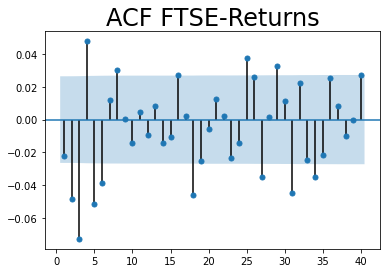

In [19]:
sgt.plot_acf(df.returns, lags = 40, zero = False)
plt.title("ACF FTSE-Returns", size = 24)
plt.show()

### MA(1) for returns

In [20]:
model_ret_ma_1 = sta.ARMA(df.returns[1:], order = (0, 1))
result_ret_ma_1 = model_ret_ma_1.fit()
result_ret_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(0, 1)   Log Likelihood               -8587.651
Method:                       css-mle   S.D. of innovations              1.142
Date:                Tue, 21 Jul 2020   AIC                          17181.302
Time:                        17:47:40   BIC                          17201.158
Sample:                    01-11-1994   HQIC                         17188.226
                         - 03-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.015      1.274      0.203      -0.010       0.048
ma.L1.returns    -0.0245      0.014     -1.724      0.085      -0.052       0.003
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           40.7956           +0.0000j           40.7956            0.0000
-----------------------------------------------------------------------------
"""

## Higher Lag MA models

In [21]:
model_ret_ma_2 = sta.ARMA(df.returns[1:], order = (0, 2))
result_ret_ma_2 = model_ret_ma_2.fit()
print(result_ret_ma_2.summary())
print("\nLLR test p-value = "+ str(LLR_test(model_ret_ma_1, model_ret_ma_2)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(0, 2)   Log Likelihood               -8580.702
Method:                       css-mle   S.D. of innovations              1.140
Date:                Tue, 21 Jul 2020   AIC                          17169.404
Time:                        17:47:40   BIC                          17195.879
Sample:                    01-11-1994   HQIC                         17178.635
                         - 03-30-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.014      1.353      0.176      -0.009       0.047
ma.L1.returns    -0.0307      0.014     -2.267      0.023      -0.057      -0.004
ma.L2.returns    -0.0487      0.013     

In [22]:
model_ret_ma_3 = sta.ARMA(df.returns[1:], order = (0, 3))
result_ret_ma_3 = model_ret_ma_3.fit()
print(result_ret_ma_3.summary())
print("\nLLR test p-value = "+ str(LLR_test(model_ret_ma_2, model_ret_ma_3)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(0, 3)   Log Likelihood               -8563.471
Method:                       css-mle   S.D. of innovations              1.137
Date:                Tue, 21 Jul 2020   AIC                          17136.942
Time:                        17:47:41   BIC                          17170.036
Sample:                    01-11-1994   HQIC                         17148.481
                         - 03-30-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.013      1.485      0.137      -0.006       0.044
ma.L1.returns    -0.0201      0.014     -1.481      0.139      -0.047       0.006
ma.L2.returns    -0.0535      0.013     

In [23]:
model_ret_ma_4 = sta.ARMA(df.returns[1:], order = (0, 4))
result_ret_ma_4 = model_ret_ma_4.fit()
print(result_ret_ma_4.summary())
print("\nLLR test p-value = "+ str(LLR_test(model_ret_ma_3, model_ret_ma_4)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(0, 4)   Log Likelihood               -8558.338
Method:                       css-mle   S.D. of innovations              1.136
Date:                Tue, 21 Jul 2020   AIC                          17128.676
Time:                        17:47:42   BIC                          17168.389
Sample:                    01-11-1994   HQIC                         17142.523
                         - 03-30-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.014      1.417      0.156      -0.007       0.046
ma.L1.returns    -0.0198      0.013     -1.476      0.140      -0.046       0.006
ma.L2.returns    -0.0532      0.013     

In [24]:
model_ret_ma_5 = sta.ARMA(df.returns[1:], order = (0, 5))
result_ret_ma_5 = model_ret_ma_5.fit()
print(result_ret_ma_5.summary())
print("\nLLR test p-value = "+ str(LLR_test(model_ret_ma_4, model_ret_ma_5)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(0, 5)   Log Likelihood               -8552.078
Method:                       css-mle   S.D. of innovations              1.134
Date:                Tue, 21 Jul 2020   AIC                          17118.157
Time:                        17:47:44   BIC                          17164.489
Sample:                    01-11-1994   HQIC                         17134.312
                         - 03-30-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.013      1.491      0.136      -0.006       0.044
ma.L1.returns    -0.0251      0.013     -1.860      0.063      -0.051       0.001
ma.L2.returns    -0.0482      0.013     

In [25]:
model_ret_ma_6 = sta.ARMA(df.returns[1:], order = (0, 6))
result_ret_ma_6 = model_ret_ma_6.fit()
print(result_ret_ma_6.summary())
print("\nLLR test p-value = "+ str(LLR_test(model_ret_ma_5, model_ret_ma_6)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(0, 6)   Log Likelihood               -8548.773
Method:                       css-mle   S.D. of innovations              1.134
Date:                Tue, 21 Jul 2020   AIC                          17113.546
Time:                        17:47:47   BIC                          17166.497
Sample:                    01-11-1994   HQIC                         17132.009
                         - 03-30-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.012      1.544      0.123      -0.005       0.043
ma.L1.returns    -0.0227      0.013     -1.691      0.091      -0.049       0.004
ma.L2.returns    -0.0475      0.013     

In [26]:
model_ret_ma_7 = sta.ARMA(df.returns[1:], order = (0, 7))
result_ret_ma_7 = model_ret_ma_7.fit()
print(result_ret_ma_7.summary())
print("\nLLR test p-value = "+ str(LLR_test(model_ret_ma_6, model_ret_ma_7)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(0, 7)   Log Likelihood               -8548.502
Method:                       css-mle   S.D. of innovations              1.134
Date:                Tue, 21 Jul 2020   AIC                          17115.003
Time:                        17:47:52   BIC                          17174.573
Sample:                    01-11-1994   HQIC                         17135.774
                         - 03-30-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.013      1.529      0.126      -0.005       0.044
ma.L1.returns    -0.0237      0.013     -1.757      0.079      -0.050       0.003
ma.L2.returns    -0.0478      0.013     

In [27]:
model_ret_ma_8 = sta.ARMA(df.returns[1:], order = (0, 8))
result_ret_ma_8 = model_ret_ma_8.fit()
print(result_ret_ma_8.summary())
print("\nLLR test p-value = "+ str(LLR_test(model_ret_ma_7, model_ret_ma_8)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(0, 8)   Log Likelihood               -8545.808
Method:                       css-mle   S.D. of innovations              1.133
Date:                Tue, 21 Jul 2020   AIC                          17111.615
Time:                        17:48:00   BIC                          17177.804
Sample:                    01-11-1994   HQIC                         17134.695
                         - 03-30-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.013      1.479      0.139      -0.006       0.045
ma.L1.returns    -0.0231      0.013     -1.718      0.086      -0.049       0.003
ma.L2.returns    -0.0482      0.013     

In [28]:
LLR_test(model_ret_ma_6, model_ret_ma_8, DF=2)

0.052

We can see clearly that the value is higher than 0.05 so model 6 is better to go with than 8.

In [29]:
LLR_test(model_ret_ma_5, model_ret_ma_8, DF=3)

0.006

We can see clearly that the value is lower than 0.05 so model 8 is better to go with than 5.

We select model 6 as the final model.

## Residual of Returns

In [30]:
df['res_ret_ma_6'] = result_ret_ma_6.resid[1:]

In [31]:
print("The mean of residual is: " + str(round(df.res_ret_ma_6.mean(), 3)))
print("The variance of residual is: " + str(round(df.res_ret_ma_6.var(), 3)))

The mean of residual is: 0.0
The variance of residual is: 1.286


In [32]:
import math
round(math.sqrt(df.res_ret_ma_6.var()), 3)

1.134

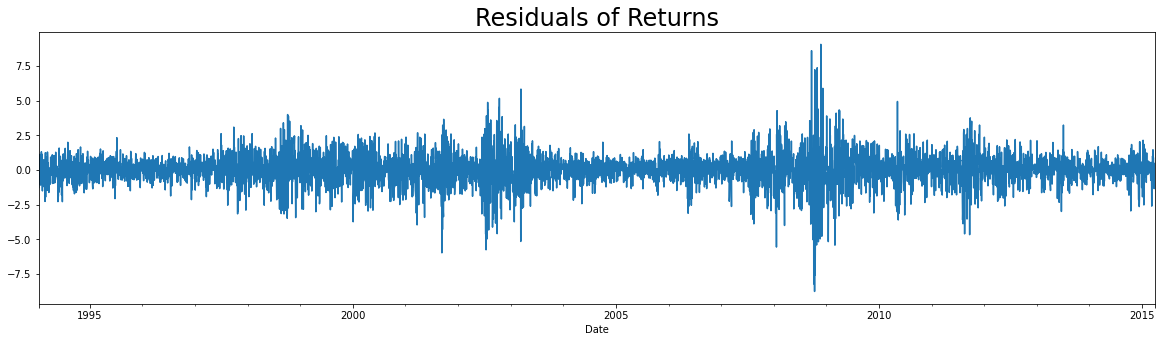

In [33]:
df.res_ret_ma_6[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

In [34]:
sts.adfuller(df.res_ret_ma_6[2:])

(-13.90948326725127,
 5.544153739612373e-26,
 33,
 5500,
 {'1%': -3.4315395190228877,
  '5%': -2.8620656492985126,
  '10%': -2.567049801950413},
 16997.35305368134)

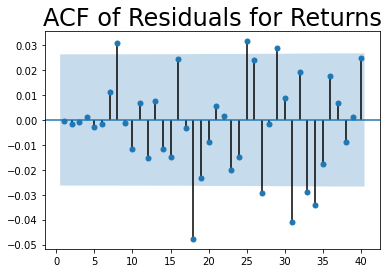

In [35]:
sgt.plot_acf(df.res_ret_ma_6[2:], zero = False, lags = 40)
plt.title("ACF of Residuals for Returns", size = 24)
plt.show()

## Normalized Returns

In [36]:
bench_ret = df.returns.iloc[1]
df['norm_ret'] = df.returns.div(bench_ret).mul(100)

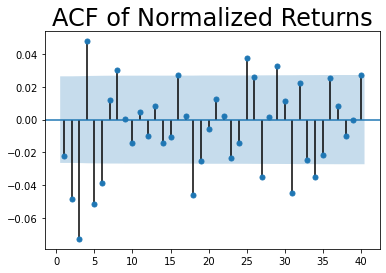

In [37]:
sgt.plot_acf(df.norm_ret[1:], zero = False, lags = 40)
plt.title("ACF of Normalized Returns", size = 24)
plt.show()

In [38]:
model_norm_ret_ma_6 = sta.ARMA(df.norm_ret[1:], order = (0, 6))
result_norm_ret_ma_6 = model_norm_ret_ma_6.fit()
print(result_norm_ret_ma_6.summary())

                              ARMA Model Results                              
Dep. Variable:               norm_ret   No. Observations:                 5535
Model:                     ARMA(0, 6)   Log Likelihood              -35421.184
Method:                       css-mle   S.D. of innovations            145.554
Date:                Tue, 21 Jul 2020   AIC                          70858.368
Time:                        17:48:17   BIC                          70911.319
Sample:                    01-11-1994   HQIC                         70876.831
                         - 03-30-2015                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -2.4576      1.592     -1.543      0.123      -5.579       0.664
ma.L1.norm_ret    -0.0227      0.013     -1.691      0.091      -0.049       0.004
ma.L2.norm_ret    -0.0475      0.013

In [39]:
print(result_ret_ma_6.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(0, 6)   Log Likelihood               -8548.773
Method:                       css-mle   S.D. of innovations              1.134
Date:                Tue, 21 Jul 2020   AIC                          17113.546
Time:                        17:48:17   BIC                          17166.497
Sample:                    01-11-1994   HQIC                         17132.009
                         - 03-30-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.012      1.544      0.123      -0.005       0.043
ma.L1.returns    -0.0227      0.013     -1.691      0.091      -0.049       0.004
ma.L2.returns    -0.0475      0.013     

In [40]:
df['res_norm_ret_ma_6'] = result_norm_ret_ma_6.resid[1:]

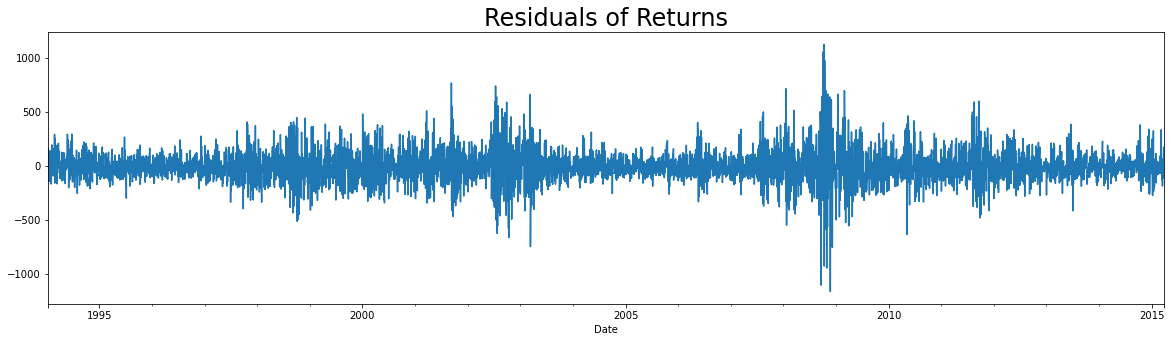

In [41]:
df.res_norm_ret_ma_6[1:].plot(figsize = (20,5))
plt.title("Residuals of Returns", size = 24)
plt.show()

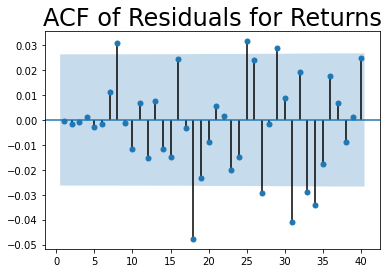

In [42]:
sgt.plot_acf(df.res_norm_ret_ma_6[2:], zero = False, lags = 40)
plt.title("ACF of Residuals for Returns", size = 24)
plt.show()

## MA Model for Prices

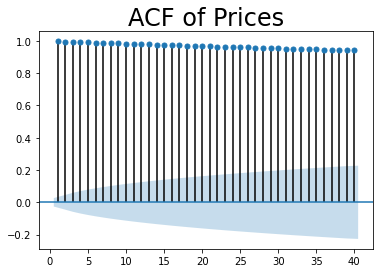

In [43]:
sgt.plot_acf(df.market_value, zero = False, lags = 40)
plt.title("ACF of Prices", size = 24)
plt.show()

According to the above graph with the increment of lags the model accuracy will increase but that is not correct so lets try some more models on this data.

ARMA: AutoRegressive Moving Average Model
(P1, P2): P1 = Lagged Values, P2 = Lagged Errors


In [44]:
model_ma_1 = sta.ARMA(df.market_value, order = (0, 1))
result_model_ma_1 = model_ma_1.fit()
print(result_model_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:           market_value   No. Observations:                 5536
Model:                     ARMA(0, 1)   Log Likelihood              -42850.168
Method:                       css-mle   S.D. of innovations            556.188
Date:                Tue, 21 Jul 2020   AIC                          85706.336
Time:                        17:48:20   BIC                          85726.193
Sample:                    01-10-1994   HQIC                         85713.260
                         - 03-30-2015                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5234.2450     14.656    357.140      0.000    5205.520    5262.970
ma.L1.market_value     0.9608      0.003    368.008      0.000       0.956       0.966
                    

### ARMA Equation

We have 2 types of ARMA model:

1. ARMA is represented with 2 components (AR,MA)

    AR is the AutoRegressive components

    MA is the MovingAverage components
    
    
    
2. ARMA is represented with 2 components (P, Q)

    P takes the previous values upto P periods
    
    Q takes the residual values upto Q lags

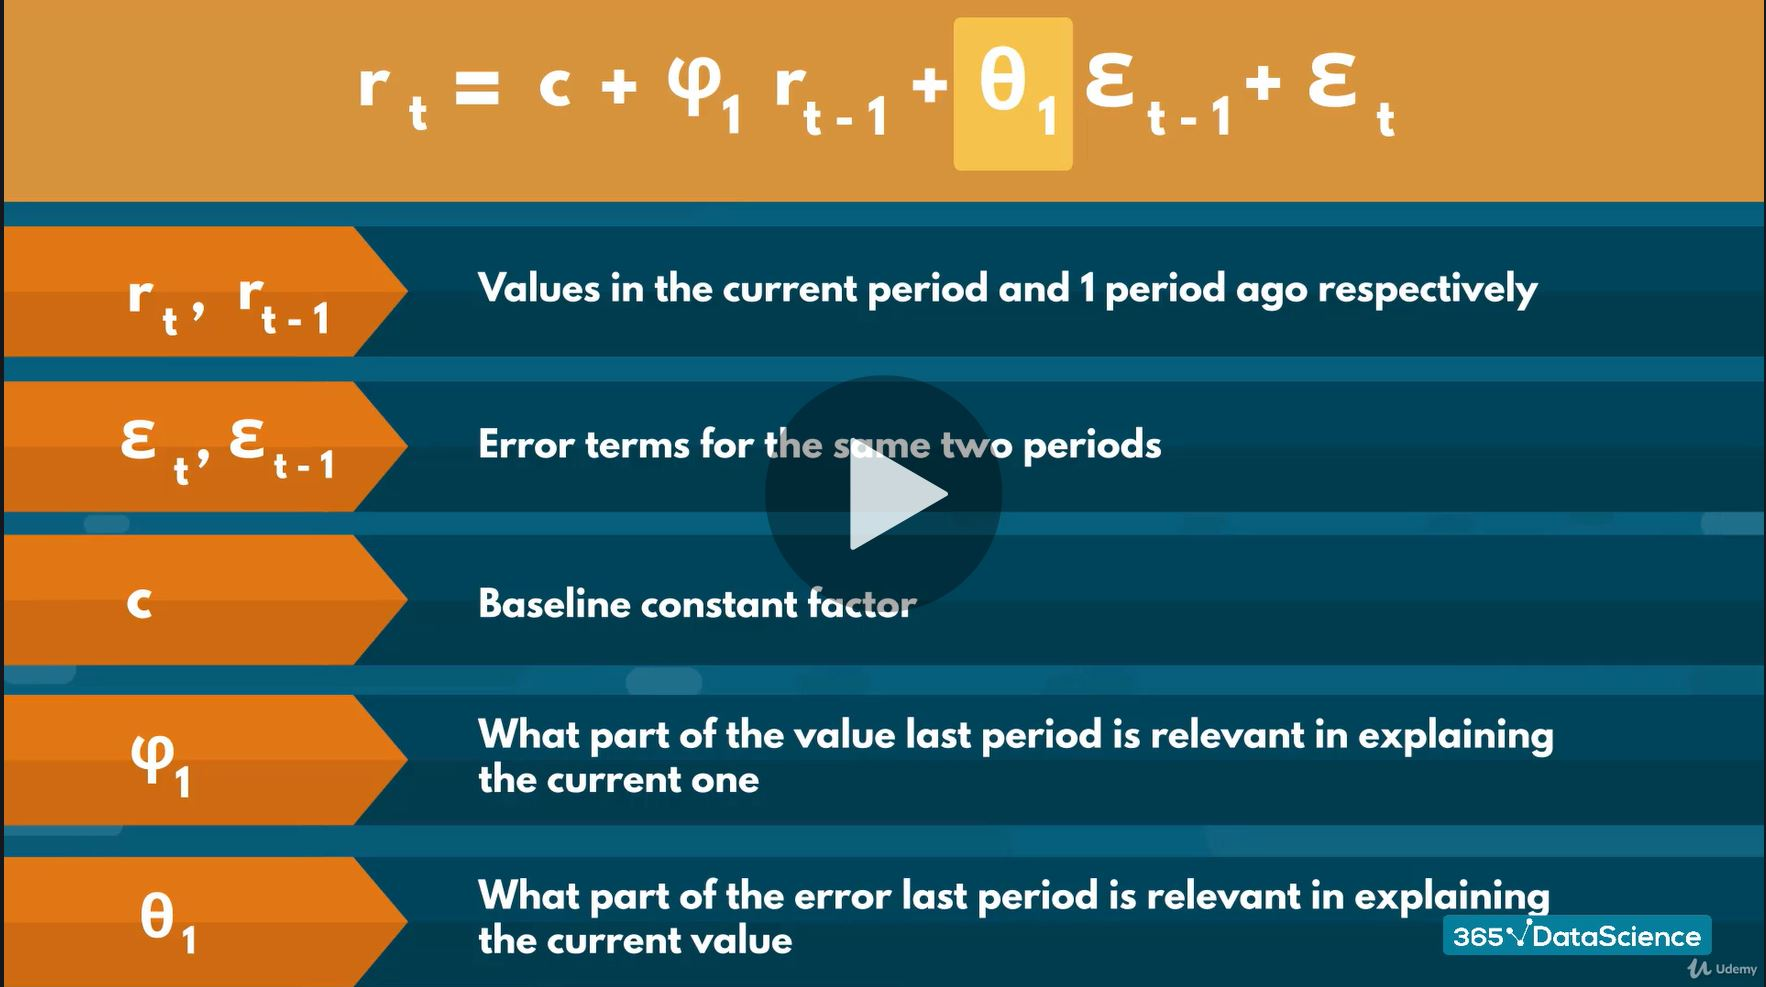

In [45]:
Image(filename='ARMAeqn.jpg')

## ARMA (1,1)

Here we will try to fit a time-series in a simple auto-regressive moving average model. Order will be of type (one previous value, one past error term). The function would be of type:

ARMA(time_series_name, order = (previous value, past error term))

In [46]:
model_ret_ar_1_ma_1 = sta.ARMA(df.returns[1:], order = (1, 1))
result_ret_ar_1_ma_1 = model_ret_ar_1_ma_1.fit()
result_ret_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(1, 1)   Log Likelihood               -8574.448
Method:                       css-mle   S.D. of innovations              1.139
Date:                Tue, 21 Jul 2020   AIC                          17156.897
Time:                        17:48:23   BIC                          17183.372
Sample:                    01-11-1994   HQIC                         17166.128
                         - 03-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.012      1.580      0.114      -0.005       0.043
ar.L1.returns     0.7834      0.074     10.653      0.000       0.639       0.928
ma.L1.returns    -0.8287      0.066    -12.493      0.000      -0.959      -0.699
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2765           +0.0000j            1.2765            0.0000
MA.1            1.2067           +0.0000j            1.2067            0.0000
-----------------------------------------------------------------------------
"""

In [47]:
model_ret_ar_1 = sts.ARMA(df.returns[1:], order = (1, 0))
model_ret_ma_1 = sts.ARMA(df.returns[1:], order = (0, 1))

In [48]:
print("\n ARMA Vs. AR: " + str(LLR_test(model_ret_ar_1, model_ret_ar_1_ma_1)))
print("\n ARMA Vs. MA: " + str(LLR_test(model_ret_ma_1, model_ret_ar_1_ma_1)))


 ARMA Vs. AR: 0.0

 ARMA Vs. MA: 0.0


### Fitting a higher-lag ARMA model

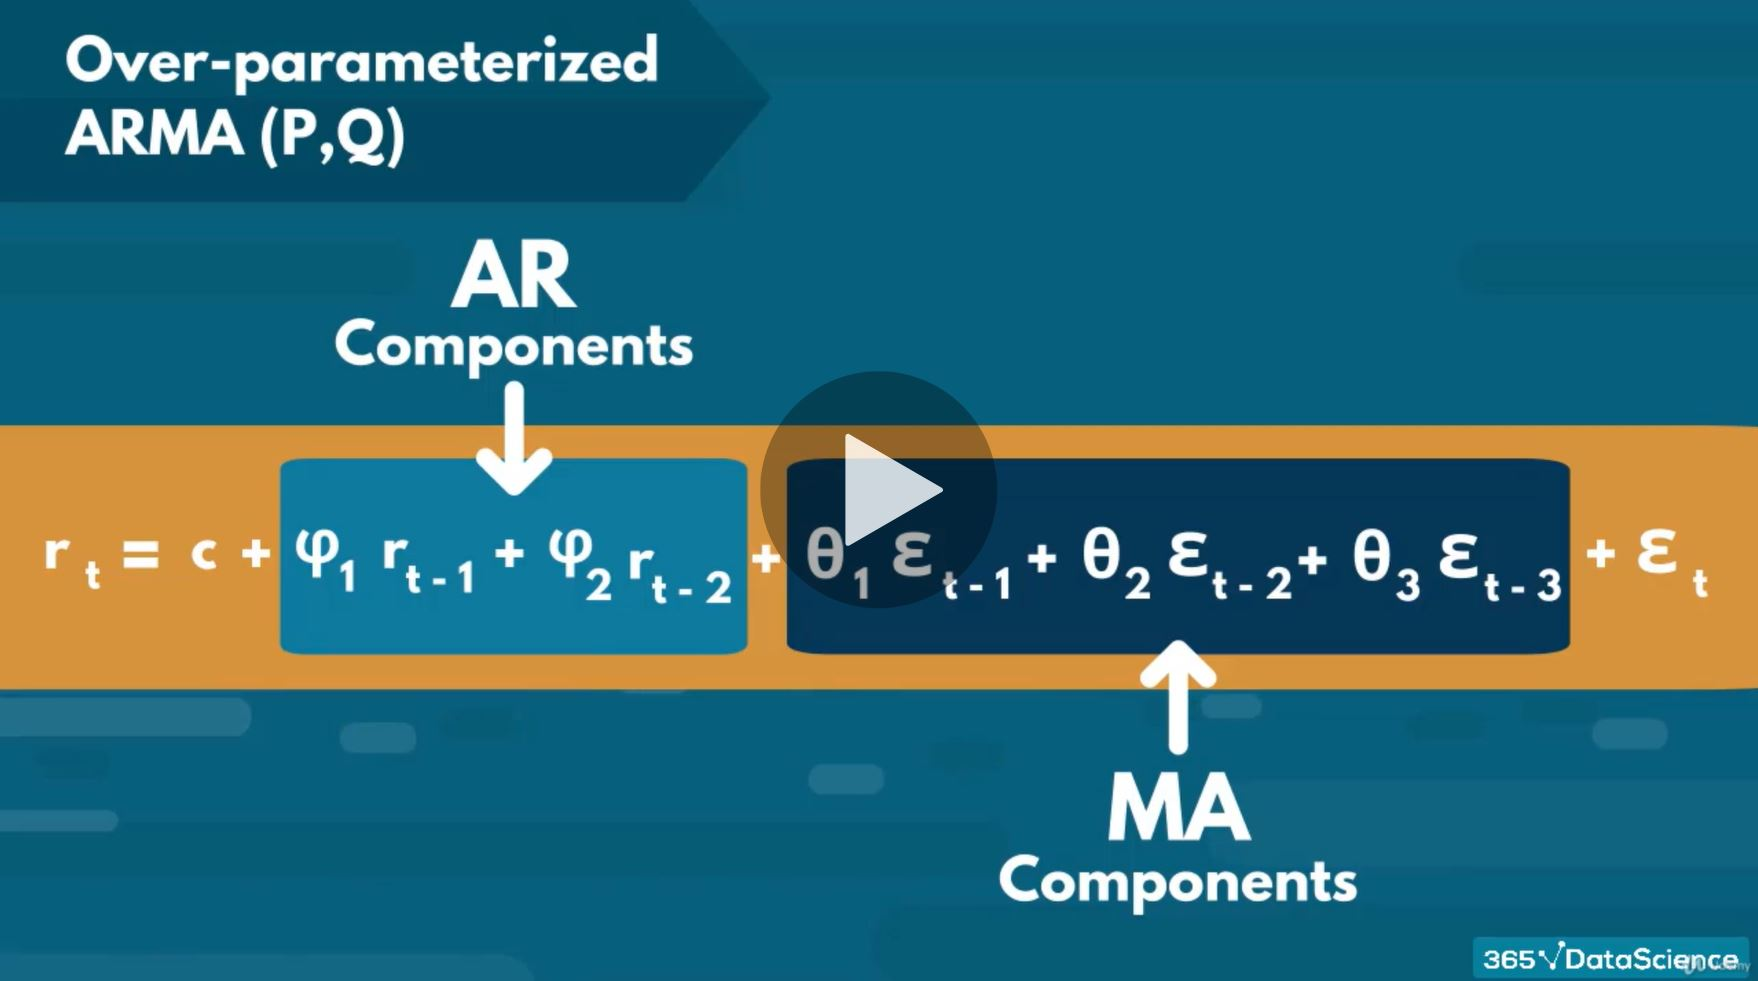

In [49]:
Image(filename='OPARMA.jpg')

The below mentioned features are the features of a best model but it might be overfitting.

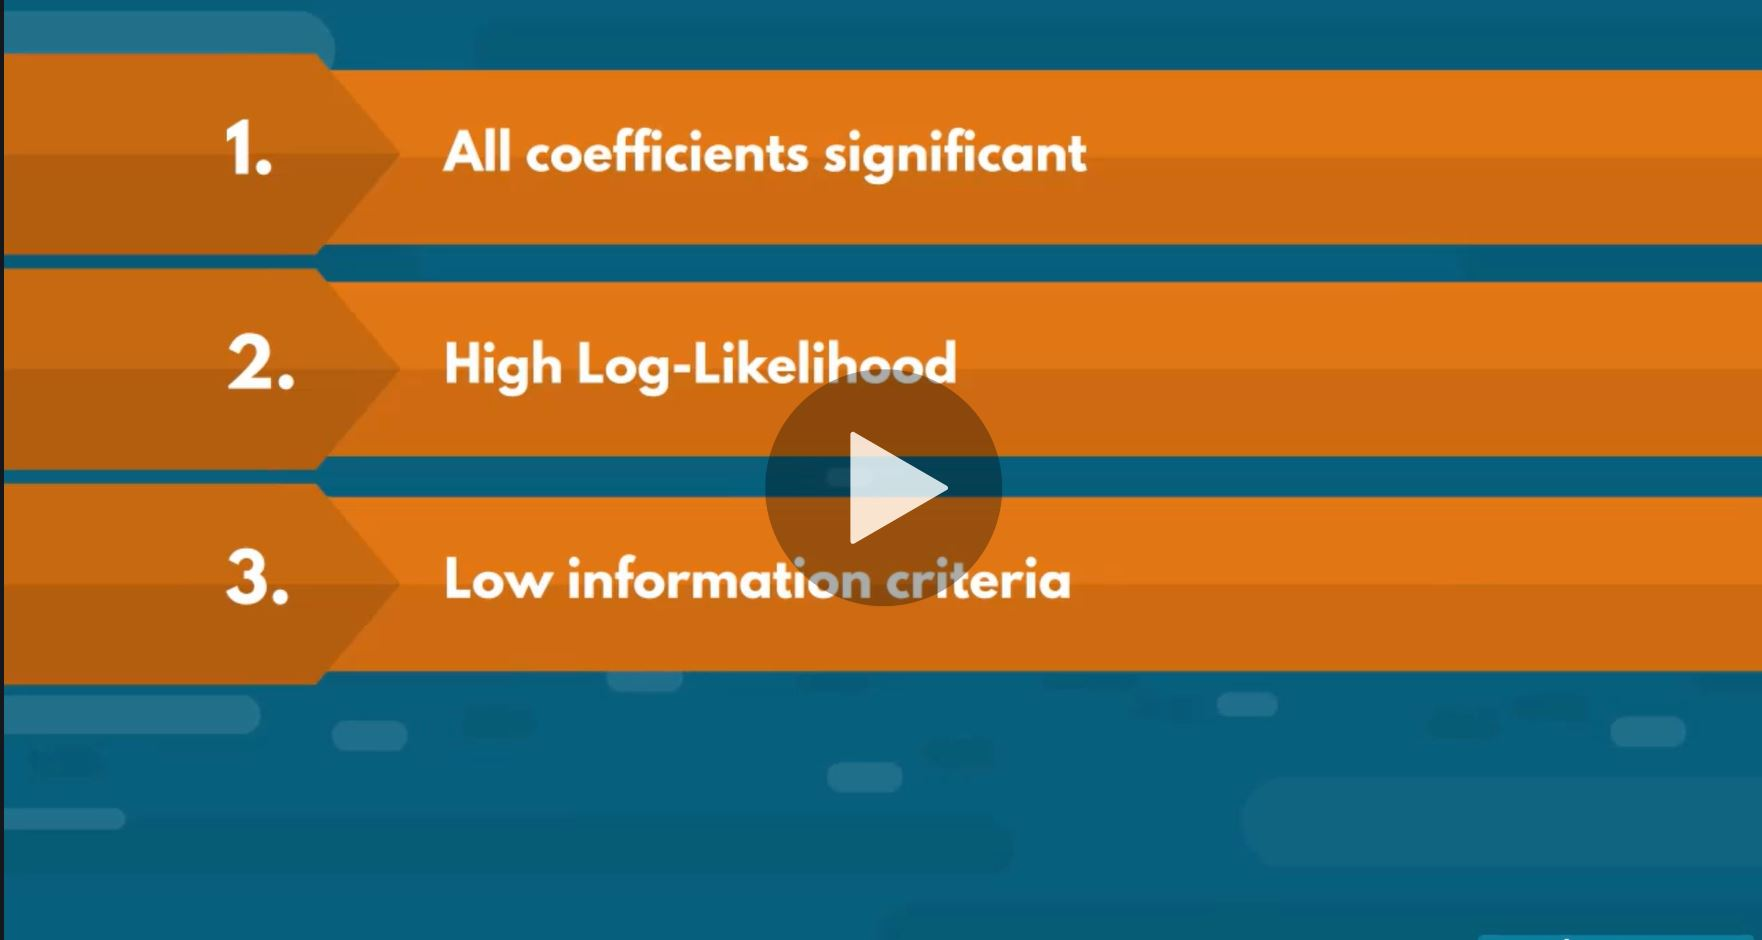

In [50]:
Image(filename='feat_ARMA.jpg')

In [51]:
model_ret_ar_3_ma_3 = sta.ARMA(df.returns[1:], order = (3, 3))
result_ret_ar_3_ma_3 = model_ret_ar_3_ma_3.fit()

In [52]:
LLR_test(model_ret_ar_1_ma_1, model_ret_ar_3_ma_3, DF = 4)

# Here DF = 4 because 1st model has 2 coefficients and second model has 6.
# So, 6-2 = 4

0.0

In [53]:
result_ret_ar_3_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(3, 3)   Log Likelihood               -8551.945
Method:                       css-mle   S.D. of innovations              1.134
Date:                Tue, 21 Jul 2020   AIC                          17119.890
Time:                        17:48:46   BIC                          17172.841
Sample:                    01-11-1994   HQIC                         17138.353
                         - 03-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.013      1.527      0.127      -0.005       0.044
ar.L1.returns    -0.1740      0.088     -1.978      0.048      -0.346      -0.002
ar.L2.returns    -0.3081      0.074     -4.159      0.000      -0.453      -0.163
ar.L3.returns     0.5548      0.119      4.659      0.000       0.321       0.788
ma.L1.returns     0.1532      0.082      1.866      0.062      -0.008       0.314
ma.L2.returns     0.2472      0.071      3.483      0.000       0.108       0.386
ma.L3.returns    -0.6376      0.110     -5.807      0.000      -0.853      -0.422
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4874           -0.9697j            1.0853           -0.3241
AR.2           -0.4874           +0.9697j            1.0853            0.3241
AR.3            1.5301           -0.0000j            1.5301           -0.0000
MA.1           -0.4973           -0.9419j            1.0652           -0.3273
MA.2           -0.4973           +0.9419j            1.0652            0.3273
MA.3            1.3823           -0.0000j            1.3823           -0.0000
-----------------------------------------------------------------------------
"""

According to the p-values there is only one component which is of no use rest are really good.

In [54]:
model_ret_ar_3_ma_2 = sta.ARMA(df.returns[1:], order = (3, 2))
result_ret_ar_3_ma_2 = model_ret_ar_3_ma_2.fit()
result_ret_ar_3_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(3, 2)   Log Likelihood               -8555.431
Method:                       css-mle   S.D. of innovations              1.135
Date:                Tue, 21 Jul 2020   AIC                          17124.863
Time:                        17:48:49   BIC                          17171.195
Sample:                    01-11-1994   HQIC                         17141.018
                         - 03-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.014      1.365      0.172      -0.008       0.047
ar.L1.returns    -0.6864      0.091     -7.513      0.000      -0.865      -0.507
ar.L2.returns    -0.4855      0.147     -3.302      0.001      -0.774      -0.197
ar.L3.returns    -0.1069      0.014     -7.599      0.000      -0.135      -0.079
ma.L1.returns     0.6654      0.092      7.270      0.000       0.486       0.845
ma.L2.returns     0.4255      0.149      2.854      0.004       0.133       0.718
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5367           -1.5523j            1.6425           -0.3030
AR.2           -0.5367           +1.5523j            1.6425            0.3030
AR.3           -3.4666           -0.0000j            3.4666           -0.5000
MA.1           -0.7819           -1.3186j            1.5331           -0.3352
MA.2           -0.7819           +1.3186j            1.5331            0.3352
-----------------------------------------------------------------------------
"""

In a complex model like 3,2 or 2,3 we should avoid doing the LLR test. Because it becomes too complex and the figures that we get are not accurate.

In [55]:
model_ret_ar_2_ma_3 = sta.ARMA(df.returns[1:], order = (2, 3))
result_ret_ar_2_ma_3 = model_ret_ar_2_ma_3.fit()
result_ret_ar_2_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(2, 3)   Log Likelihood               -8555.186
Method:                       css-mle   S.D. of innovations              1.135
Date:                Tue, 21 Jul 2020   AIC                          17124.372
Time:                        17:48:52   BIC                          17170.704
Sample:                    01-11-1994   HQIC                         17140.528
                         - 03-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.014      1.393      0.164      -0.008       0.046
ar.L1.returns    -0.5723      0.095     -6.033      0.000      -0.758      -0.386
ar.L2.returns    -0.3679      0.274     -1.341      0.180      -0.905       0.170
ma.L1.returns     0.5504      0.095      5.812      0.000       0.365       0.736
ma.L2.returns     0.3048      0.276      1.105      0.269      -0.236       0.846
ma.L3.returns    -0.1095      0.015     -7.144      0.000      -0.140      -0.079
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.7779           -1.4537j            1.6487           -0.3282
AR.2           -0.7779           +1.4537j            1.6487            0.3282
MA.1           -0.8075           -1.1934j            1.4409           -0.3447
MA.2           -0.8075           +1.1934j            1.4409            0.3447
MA.3            4.3981           -0.0000j            4.3981           -0.0000
-----------------------------------------------------------------------------
"""

According to the p-values there are 2 components which are of no use, so we can go lower in this kind of models.

In [56]:
LLR_test(model_ret_ar_2_ma_3 ,model_ret_ar_3_ma_3, DF = 1)

0.011

In [57]:
# ARMA (3,1)
model_ret_ar_3_ma_1 = sta.ARMA(df.returns[1:], order = (3, 1))
result_ret_ar_3_ma_1 = model_ret_ar_3_ma_1.fit()
result_ret_ar_3_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(3, 1)   Log Likelihood               -8558.495
Method:                       css-mle   S.D. of innovations              1.136
Date:                Tue, 21 Jul 2020   AIC                          17128.990
Time:                        17:49:02   BIC                          17168.703
Sample:                    01-11-1994   HQIC                         17142.837
                         - 03-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.014      1.411      0.158      -0.007       0.046
ar.L1.returns    -0.5055      0.090     -5.624      0.000      -0.682      -0.329
ar.L2.returns    -0.0615      0.015     -4.075      0.000      -0.091      -0.032
ar.L3.returns    -0.1026      0.013     -7.676      0.000      -0.129      -0.076
ma.L1.returns     0.4825      0.090      5.371      0.000       0.306       0.659
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5329           -0.0000j            1.5329           -0.5000
AR.2            0.4666           -2.4776j            2.5212           -0.2204
AR.3            0.4666           +2.4776j            2.5212            0.2204
MA.1           -2.0724           +0.0000j            2.0724            0.5000
-----------------------------------------------------------------------------
"""

We can clearly see that all the p-values are significant and the AR coefficients are all negative while the MA coefficient is positive. Lets just jump to LLR test this is a good model.

In [58]:
LLR_test(model_ret_ar_3_ma_1 ,model_ret_ar_3_ma_2, DF = 1)

# Always put the simpler model first else the LLR test will always return 1.

0.013

In [59]:
# ARMA(2,2)
model_ret_ar_2_ma_2 = sta.ARMA(df.returns[1:], order = (2, 2))
result_ret_ar_2_ma_2 = model_ret_ar_2_ma_2.fit()
result_ret_ar_2_ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(2, 2)   Log Likelihood               -8571.407
Method:                       css-mle   S.D. of innovations              1.138
Date:                Tue, 21 Jul 2020   AIC                          17154.815
Time:                        17:49:08   BIC                          17194.528
Sample:                    01-11-1994   HQIC                         17168.662
                         - 03-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.013      1.508      0.132      -0.006       0.044
ar.L1.returns     0.7684      0.235      3.264      0.001       0.307       1.230
ar.L2.returns    -0.1449      0.178     -0.815      0.415      -0.493       0.204
ma.L1.returns    -0.7953      0.236     -3.365      0.001      -1.259      -0.332
ma.L2.returns     0.1076      0.187      0.575      0.566      -0.259       0.475
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.2900           +0.0000j            2.2900            0.0000
AR.2            3.0145           +0.0000j            3.0145            0.0000
MA.1            1.6065           +0.0000j            1.6065            0.0000
MA.2            5.7842           +0.0000j            5.7842            0.0000
-----------------------------------------------------------------------------
"""

We can clearly see that 2 p-values are insignificant. This is not a good model

In [60]:
#ARMA(1,3)
model_ret_ar_1_ma_3 = sta.ARMA(df.returns[1:], order = (1, 3))
result_ret_ar_1_ma_3 = model_ret_ar_1_ma_3.fit()
result_ret_ar_1_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(1, 3)   Log Likelihood               -8556.334
Method:                       css-mle   S.D. of innovations              1.135
Date:                Tue, 21 Jul 2020   AIC                          17124.668
Time:                        17:49:10   BIC                          17164.381
Sample:                    01-11-1994   HQIC                         17138.516
                         - 03-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.013      1.444      0.149      -0.007       0.045
ar.L1.returns    -0.4724      0.096     -4.932      0.000      -0.660      -0.285
ma.L1.returns     0.4507      0.095      4.726      0.000       0.264       0.638
ma.L2.returns    -0.0617      0.015     -4.177      0.000      -0.091      -0.033
ma.L3.returns    -0.1102      0.014     -8.007      0.000      -0.137      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1166           +0.0000j            2.1166            0.5000
MA.1           -1.5351           -1.1222j            1.9015           -0.3995
MA.2           -1.5351           +1.1222j            1.9015            0.3995
MA.3            2.5103           -0.0000j            2.5103           -0.0000
-----------------------------------------------------------------------------
"""

This is a good model according the relevant p-values of all the variables. But this also a nested model. The higher lag model is considered as the nested model. For more details check the slide of the model of interest.

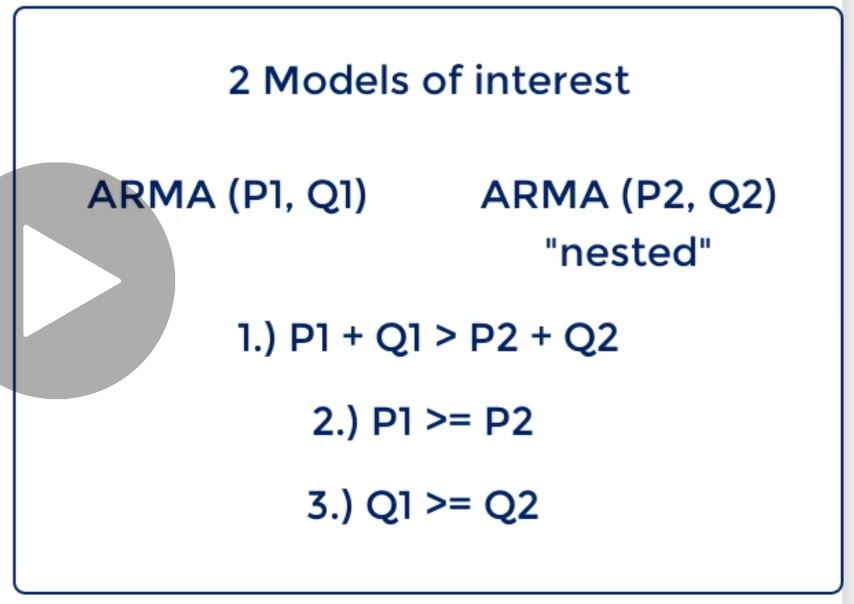

In [61]:
Image(filename='moi.jpg')

In [62]:
print("\n ARMA(3,2): LL = " + str(result_ret_ar_3_ma_2.llf), "AIC = " + str(result_ret_ar_3_ma_2.aic))
print("\n ARMA(1,3): LL = " + str(result_ret_ar_1_ma_3.llf), "AIC = " + str(result_ret_ar_1_ma_3.aic))


 ARMA(3,2): LL = -8555.431478108432 AIC = 17124.862956216864

 ARMA(1,3): LL = -8556.3341920042 AIC = 17124.6683840084


Clearly ARMA(3,2) is a better model because of the higher LLR result

### Residual of Returns

In [63]:
df['res_ret_ar_3_ma_2'] = result_ret_ar_3_ma_2.resid[1:]

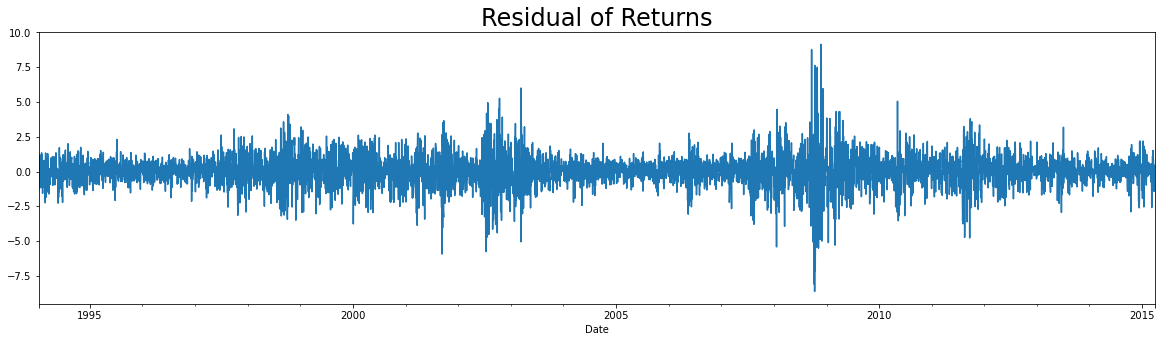

In [64]:
df.res_ret_ar_3_ma_2.plot(figsize = (20,5))
plt.title('Residual of Returns', size = 24)
plt.show()

The above results are very similar to the residuals of AR as well MA models. The volatility in returns might not be fully comprehendable if we use only ARMA model.

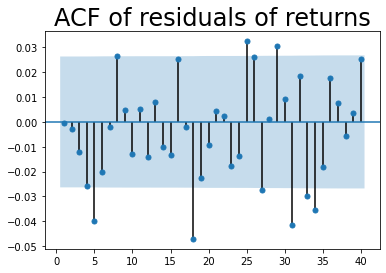

In [65]:
sgt.plot_acf(df.res_ret_ar_3_ma_2[2:], zero = False, lags = 40)
plt.title("ACF of residuals of returns", size = 24)
plt.show()

Its quiet surprising to see that we have more significant lags than AR and MA models (check the ACF plots above for the respective models). Therefore accounting for lags 5 periods ago could improve our predictions(Clearly the fifth variable is out of the blue area). So we should start with the ARMA(5,5) and go through the models regressively like ARMA(5,Q) or ARMA(P,5). Once we are prepared with all the models, we shall go ahead with the following steps.

1. Find all the models with all coefficients significant.
2. Run the LLR test for the nested ones (as done above).
3. Compare log-likelihood and AIC values for the others.

### Reevaluating Model Selection

In [66]:
#ARMA(5,5)
model_ret_ar_5_ma_5 = sta.ARMA(df.returns[1:], order = (5, 5))
result_ret_ar_5_ma_5 = model_ret_ar_5_ma_5.fit()
result_ret_ar_5_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(5, 5)   Log Likelihood               -8541.187
Method:                       css-mle   S.D. of innovations              1.132
Date:                Tue, 21 Jul 2020   AIC                          17106.375
Time:                        17:49:26   BIC                          17185.801
Sample:                    01-11-1994   HQIC                         17134.070
                         - 03-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0191      0.013      1.518      0.129      -0.006       0.044
ar.L1.returns    -0.0906      0.139     -0.651      0.515      -0.363       0.182
ar.L2.returns    -0.6814      0.144     -4.718      0.000      -0.964      -0.398
ar.L3.returns    -0.1172      0.144     -0.817      0.414      -0.399       0.164
ar.L4.returns     0.1730      0.129      1.337      0.181      -0.081       0.427
ar.L5.returns     0.1505      0.107      1.405      0.160      -0.059       0.360
ma.L1.returns     0.0675      0.137      0.492      0.622      -0.201       0.336
ma.L2.returns     0.6325      0.142      4.450      0.000       0.354       0.911
ma.L3.returns     0.0190      0.138      0.137      0.891      -0.252       0.290
ma.L4.returns    -0.1752      0.123     -1.424      0.154      -0.416       0.066
ma.L5.returns    -0.2468      0.103     -2.387      0.017      -0.449      -0.044
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0893           -1.0288j            1.0327           -0.2362
AR.2            0.0893           +1.0288j            1.0327            0.2362
AR.3            1.7182           -0.0000j            1.7182           -0.0000
AR.4           -1.5233           -1.1429j            1.9044           -0.3976
AR.5           -1.5233           +1.1429j            1.9044            0.3976
MA.1            0.1030           -1.0342j            1.0393           -0.2342
MA.2            0.1030           +1.0342j            1.0393            0.2342
MA.3            1.4724           -0.0000j            1.4724           -0.0000
MA.4           -1.1941           -1.0593j            1.5962           -0.3845
MA.5           -1.1941           +1.0593j            1.5962            0.3845
-----------------------------------------------------------------------------
"""

We can clearly see that there are many variables whose p-value is greater than 0.05, so this is not a good model. The only good models that were found are (5,1) and (1,5) so we shall go ahead with them but we cannot perform the log-likelyhood test as the they have the same degree of freedom. So we will only compare their AIC and log-likelyhood values.

In [67]:
#ARMA(5,1)
model_ret_ar_5_ma_1 = sta.ARMA(df.returns[1:], order = (5, 1))
result_ret_ar_5_ma_1 = model_ret_ar_5_ma_1.fit()
result_ret_ar_5_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(5, 1)   Log Likelihood               -8549.077
Method:                       css-mle   S.D. of innovations              1.134
Date:                Tue, 21 Jul 2020   AIC                          17114.155
Time:                        17:49:31   BIC                          17167.105
Sample:                    01-11-1994   HQIC                         17132.618
                         - 03-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.013      1.521      0.128      -0.006       0.044
ar.L1.returns     0.3314      0.134      2.469      0.014       0.068       0.594
ar.L2.returns    -0.0444      0.014     -3.065      0.002      -0.073      -0.016
ar.L3.returns    -0.0598      0.016     -3.841      0.000      -0.090      -0.029
ar.L4.returns     0.0666      0.017      3.860      0.000       0.033       0.100
ar.L5.returns    -0.0755      0.014     -5.549      0.000      -0.102      -0.049
ma.L1.returns    -0.3539      0.134     -2.636      0.008      -0.617      -0.091
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.6455           -0.0000j            1.6455           -0.5000
AR.2            1.3944           -0.8778j            1.6477           -0.0894
AR.3            1.3944           +0.8778j            1.6477            0.0894
AR.4           -0.1306           -1.7168j            1.7218           -0.2621
AR.5           -0.1306           +1.7168j            1.7218            0.2621
MA.1            2.8258           +0.0000j            2.8258            0.0000
-----------------------------------------------------------------------------
"""

In [68]:
#ARMA(1,5)
model_ret_ar_1_ma_5 = sta.ARMA(df.returns[1:], order = (1, 5))
result_ret_ar_1_ma_5 = model_ret_ar_1_ma_5.fit()
result_ret_ar_1_ma_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                 5535
Model:                     ARMA(1, 5)   Log Likelihood               -8550.368
Method:                       css-mle   S.D. of innovations              1.134
Date:                Tue, 21 Jul 2020   AIC                          17116.737
Time:                        17:49:34   BIC                          17169.687
Sample:                    01-11-1994   HQIC                         17135.200
                         - 03-30-2015                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0192      0.012      1.533      0.125      -0.005       0.044
ar.L1.returns     0.3165      0.154      2.052      0.040       0.014       0.619
ma.L1.returns    -0.3404      0.154     -2.215      0.027      -0.642      -0.039
ma.L2.returns    -0.0398      0.015     -2.723      0.006      -0.068      -0.011
ma.L3.returns    -0.0622      0.016     -3.855      0.000      -0.094      -0.031
ma.L4.returns     0.0675      0.019      3.643      0.000       0.031       0.104
ma.L5.returns    -0.0650      0.014     -4.639      0.000      -0.092      -0.038
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1595           +0.0000j            3.1595            0.0000
MA.1           -1.2126           -1.1635j            1.6805           -0.3783
MA.2           -1.2126           +1.1635j            1.6805            0.3783
MA.3            1.5231           -0.0000j            1.5231           -0.0000
MA.4            0.9702           -1.6233j            1.8911           -0.1643
MA.5            0.9702           +1.6233j            1.8911            0.1643
-----------------------------------------------------------------------------
"""

In [69]:
print("\n ARMA(5,1): LL = " + str(result_ret_ar_5_ma_1.llf), "AIC = " + str(result_ret_ar_5_ma_1.aic))
print("\n ARMA(1,5): LL = " + str(result_ret_ar_1_ma_5.llf), "AIC = " + str(result_ret_ar_1_ma_5.aic))


 ARMA(5,1): LL = -8549.077264690597 AIC = 17114.154529381194

 ARMA(1,5): LL = -8550.36825440503 AIC = 17116.73650881006


ARMA(5,1) has higher LL and lower AIC, so thats a better option. So now we have two good models ARMA(3,2) and ARMA(5,1) and both of them should be compared.

In [70]:
print("\n ARMA(3,2): LL = " + str(result_ret_ar_3_ma_2.llf), "AIC = " + str(result_ret_ar_3_ma_2.aic))
print("\n ARMA(5,1): LL = " + str(result_ret_ar_5_ma_1.llf), "AIC = " + str(result_ret_ar_5_ma_1.aic))


 ARMA(3,2): LL = -8555.431478108432 AIC = 17124.862956216864

 ARMA(5,1): LL = -8549.077264690597 AIC = 17114.154529381194


Clearly ARMA(5,1) is a better choice here.

### Residuals for the Error Terms

In [71]:
df['res_ret_ar_5_ma_1'] = result_ret_ar_5_ma_1.resid

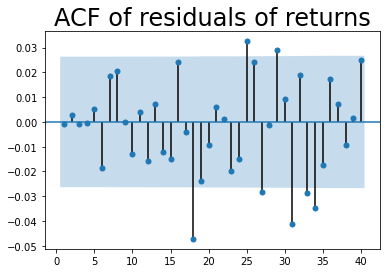

In [72]:
sgt.plot_acf(df.res_ret_ar_5_ma_1[2:], zero = False, lags = 40)
plt.title("ACF of residuals of returns", size = 24)
plt.show()

Clearly now we can see that abruption in the graph goes at around the 18th point. So we can go further but it will overfit our model also the market adjusts itself. So going beyond 15 will be cumbersome as well as resourceful task

### ARMA model for prices

We will now try to fit our model to a non-stationary data i.e. prices.

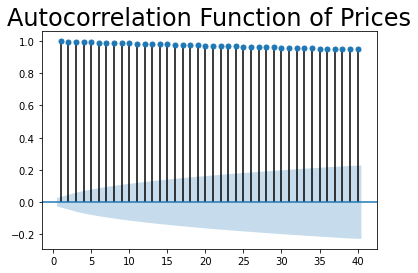

In [73]:
sgt.plot_acf(df.market_value, unbiased = True, zero = False, lags = 40)
plt.title("Autocorrelation Function of Prices", size = 24)
plt.show()

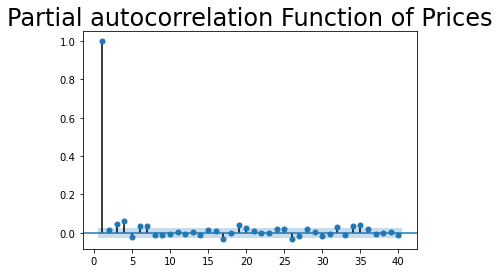

In [74]:
sgt.plot_pacf(df.market_value, alpha = 0.05, zero = False, lags = 40, method = 'ols')
plt.title("Partial autocorrelation Function of Prices", size = 24)
plt.show()

In [75]:
#ARMA(1,1)
model_prices_ar_1_ma_1 = sta.ARMA(df.market_value, order = (1, 1))
result_prices_ar_1_ma_1 = model_prices_ar_1_ma_1.fit()
result_prices_ar_1_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5536
Model:                     ARMA(1, 1)   Log Likelihood              -30375.017
Method:                       css-mle   S.D. of innovations             58.401
Date:                Tue, 21 Jul 2020   AIC                          60758.033
Time:                        17:49:36   BIC                          60784.509
Sample:                    01-10-1994   HQIC                         60767.265
                         - 03-30-2015                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5234.3408    567.742      9.220      0.000    4121.588    6347.094
ar.L1.market_value     0.9988      0.001   1502.077      0.000       0.998       1.000
ma.L1.market_value    -0.0169      0.014     -1.193      0.233      -0.045       0.011
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0012           +0.0000j            1.0012            0.0000
MA.1           59.1839           +0.0000j           59.1839            0.0000
-----------------------------------------------------------------------------
"""

In [76]:
df['res_prices_ar_1_ma_1'] = result_prices_ar_1_ma_1.resid

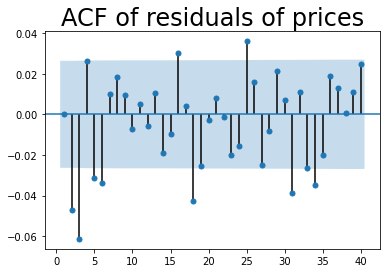

In [77]:
sgt.plot_acf(df.res_prices_ar_1_ma_1[2:], zero = False, lags = 40)
plt.title("ACF of residuals of prices", size = 24)
plt.show()

In [78]:
# Clearly we can see that we have to go for ARMA(6,6) by checking the residuals of prices

model_prices_ar_6_ma_6 = sta.ARMA(df.market_value, order = (6, 6))
result_prices_ar_6_ma_6 = model_prices_ar_6_ma_6.fit(start_ar_lags = 15)
result_prices_ar_6_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5536
Model:                     ARMA(6, 6)   Log Likelihood              -30344.398
Method:                       css-mle   S.D. of innovations             58.078
Date:                Tue, 21 Jul 2020   AIC                          60716.797
Time:                        17:49:47   BIC                          60809.463
Sample:                    01-10-1994   HQIC                         60749.108
                         - 03-30-2015                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5234.3681    664.728      7.874      0.000    3931.526    6537.210
ar.L1.market_value     0.1404      0.215      0.654      0.513      -0.281       0.561
ar.L2.market_value     0.2010      0.227      0.884      0.376      -0.244       0.646
ar.L3.market_value    -0.0652      0.175     -0.372      0.710      -0.409       0.278
ar.L4.market_value     0.7630      0.153      4.981      0.000       0.463       1.063
ar.L5.market_value     0.1886      0.152      1.239      0.215      -0.110       0.487
ar.L6.market_value    -0.2302      0.141     -1.633      0.102      -0.506       0.046
ma.L1.market_value     0.8409      0.215      3.918      0.000       0.420       1.262
ma.L2.market_value     0.5971      0.194      3.074      0.002       0.216       0.978
ma.L3.market_value     0.6072      0.225      2.697      0.007       0.166       1.048
ma.L4.market_value    -0.1169      0.170     -0.688      0.491      -0.450       0.216
ma.L5.market_value    -0.3129      0.134     -2.341      0.019      -0.575      -0.051
ma.L6.market_value    -0.0732      0.020     -3.744      0.000      -0.112      -0.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0930           -1.0350j            1.0391           -0.2357
AR.2            0.0930           +1.0350j            1.0391            0.2357
AR.3           -1.3124           -0.2415j            1.3345           -0.4710
AR.4           -1.3124           +0.2415j            1.3345            0.4710
AR.5            1.0008           -0.0000j            1.0008           -0.0000
AR.6            2.2573           -0.0000j            2.2573           -0.0000
MA.1            0.1058           -1.0411j            1.0465           -0.2339
MA.2            0.1058           +1.0411j            1.0465            0.2339
MA.3            1.6965           -0.0000j            1.6965           -0.0000
MA.4           -1.4264           -0.0000j            1.4264           -0.5000
MA.5           -1.6718           -0.0000j            1.6718           -0.5000
MA.6           -3.0830           -0.0000j            3.0830           -0.5000
-----------------------------------------------------------------------------
"""

We should try all the models but the best that were found are ARMA(5,6) and ARMA(6,1)

In [79]:
model_prices_ar_5_ma_6 = sta.ARMA(df.market_value, order = (5, 6))
result_prices_ar_5_ma_6 = model_prices_ar_5_ma_6.fit(start_ar_lags = 9)
result_prices_ar_5_ma_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5536
Model:                     ARMA(5, 6)   Log Likelihood              -30348.907
Method:                       css-mle   S.D. of innovations             58.126
Date:                Tue, 21 Jul 2020   AIC                          60723.814
Time:                        17:49:58   BIC                          60809.862
Sample:                    01-10-1994   HQIC                         60753.818
                         - 03-30-2015                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5234.3449    649.238      8.062      0.000    3961.862    6506.827
ar.L1.market_value     2.1216      0.026     81.229      0.000       2.070       2.173
ar.L2.market_value    -1.9399      0.030    -64.185      0.000      -1.999      -1.881
ar.L3.market_value     1.2555      0.025     49.488      0.000       1.206       1.305
ar.L4.market_value    -0.5964      0.042    -14.034      0.000      -0.680      -0.513
ar.L5.market_value     0.1587      0.037      4.276      0.000       0.086       0.232
ma.L1.market_value    -1.1404      0.029    -38.817      0.000      -1.198      -1.083
ma.L2.market_value     0.7920      0.025     31.283      0.000       0.742       0.842
ma.L3.market_value    -0.4643      0.030    -15.244      0.000      -0.524      -0.405
ma.L4.market_value     0.2268      0.043      5.284      0.000       0.143       0.311
ma.L5.market_value    -0.0947      0.020     -4.641      0.000      -0.135      -0.055
ma.L6.market_value     0.0444      0.014      3.113      0.002       0.016       0.072
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0244           -1.6015j            1.6017           -0.2476
AR.2            0.0244           +1.6015j            1.6017            0.2476
AR.3            1.0009           -0.0000j            1.0009           -0.0000
AR.4            1.3537           -0.7881j            1.5664           -0.0839
AR.5            1.3537           +0.7881j            1.5664            0.0839
MA.1            1.3856           -0.5722j            1.4991           -0.0623
MA.2            1.3856           +0.5722j            1.4991            0.0623
MA.3            0.5226           -1.5863j            1.6702           -0.1994
MA.4            0.5226           +1.5863j            1.6702            0.1994
MA.5           -0.8406           -1.7001j            1.8966           -0.3231
MA.6           -0.8406           +1.7001j            1.8966            0.3231
-----------------------------------------------------------------------------
"""

In [80]:
model_prices_ar_6_ma_1 = sta.ARMA(df.market_value, order = (6, 1))
result_prices_ar_6_ma_1 = model_prices_ar_6_ma_1.fit(start_ar_lags = 9)
result_prices_ar_6_ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5536
Model:                     ARMA(6, 1)   Log Likelihood              -30351.391
Method:                       css-mle   S.D. of innovations             58.152
Date:                Tue, 21 Jul 2020   AIC                          60720.782
Time:                        17:50:05   BIC                          60780.353
Sample:                    01-10-1994   HQIC                         60741.554
                         - 03-30-2015                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               5234.3418    670.709      7.804      0.000    3919.777    6548.906
ar.L1.market_value     1.3760      0.042     32.436      0.000       1.293       1.459
ar.L2.market_value    -0.4182      0.044     -9.485      0.000      -0.505      -0.332
ar.L3.market_value    -0.0043      0.023     -0.186      0.852      -0.050       0.041
ar.L4.market_value     0.0935      0.023      3.985      0.000       0.048       0.140
ar.L5.market_value    -0.0978      0.023     -4.259      0.000      -0.143      -0.053
ar.L6.market_value     0.0502      0.013      3.739      0.000       0.024       0.077
ma.L1.market_value    -0.3944      0.044     -8.893      0.000      -0.481      -0.307
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0008           -0.0000j            1.0008           -0.0000
AR.2            1.4954           -0.8941j            1.7423           -0.0858
AR.3            1.4954           +0.8941j            1.7423            0.0858
AR.4           -1.8254           -0.0000j            1.8254           -0.5000
AR.5           -0.1088           -1.8920j            1.8952           -0.2591
AR.6           -0.1088           +1.8920j            1.8952            0.2591
MA.1            2.5356           +0.0000j            2.5356            0.0000
-----------------------------------------------------------------------------
"""

In [81]:
print("\n ARMA(5,6): LL = " + str(result_prices_ar_5_ma_6.llf), "AIC = " + str(result_prices_ar_5_ma_6.aic))
print("\n ARMA(6,1): LL = " + str(result_prices_ar_6_ma_1.llf), "AIC = " + str(result_prices_ar_6_ma_1.aic))


 ARMA(5,6): LL = -30348.90723017654 AIC = 60723.81446035308

 ARMA(6,1): LL = -30351.39107755454 AIC = 60720.78215510908


In [82]:
df['res_prices_ar_5_ma_6'] = result_prices_ar_5_ma_6.resid

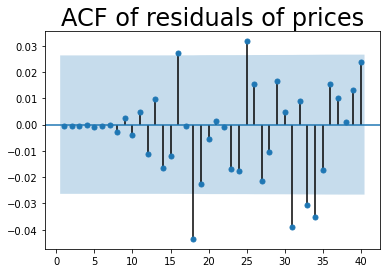

In [85]:
sgt.plot_acf(df.res_prices_ar_5_ma_6[2:], zero = False, lags = 40)
plt.title("ACF of residuals of prices", size = 24)
plt.show()

## ARMA for Returns Vs ARMA for prices

In [87]:
print("\n ARMA(5,6) for prices: LL = " + str(result_prices_ar_5_ma_6.llf), "AIC = " + str(result_prices_ar_5_ma_6.aic))
print("\n ARMA(5,1) for returns: LL = " + str(result_ret_ar_5_ma_1.llf), "AIC = " + str(result_ret_ar_5_ma_1.aic))


 ARMA(5,6) for prices: LL = -30348.90723017654 AIC = 60723.81446035308

 ARMA(5,1) for returns: LL = -8549.077264690597 AIC = 17114.154529381194


Clearly there is no match between the models. ARMA(5,1) for returns is way better when compared. To deal with such kind of problems with non-stationary data we have another strategy called ARIMA.